In [1]:
import os
import numpy as np
import pandas as pd
import math


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix


from river import compose, preprocessing, metrics, datasets
from river import evaluate
from deep_river.classification import Classifier

import deep_river
from river import compat
from river import stream
import torch.optim as optim

from collections import Counter



from deep_river.anomaly import RollingAutoencoder
from deep_river import classification

from torch import nn, manual_seed
import torch.nn.functional as F
import torch
from tqdm import tqdm


In [ ]:
# Define defaults

# Set seed for NumPy
np.random.seed(42)

FILENAME = "../../datasets/BCCC-CIC-IDS-2017/subsets/training_v1.csv"
FILENAME_TEST = "../../datasets/BCCC-CIC-IDS-2017/subsets/test_v1.csv"

In [3]:
# Load csv file
df = pd.read_csv(FILENAME, low_memory=False)
df_test = pd.read_csv(FILENAME_TEST, low_memory=False)

In [4]:
X_train = df.drop("label", axis=1)
y_train = df["label"]


X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

In [5]:
df['label'].value_counts()

label
0    364830
3    141652
1     47301
2      3878
4      2798
5      2340
Name: count, dtype: int64

In [6]:
# Prepration for Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_normalize = X_train.columns.tolist()
X_train[columns_to_normalize] = scaler.fit_transform(X_train[columns_to_normalize])

In [7]:
X_train.shape

(562799, 108)

In [8]:
print(f"y train shape: {y_train.shape}")

y train shape: (562799,)


In [9]:
# Print label distribution in y_train
print("Label distribution in y_train:")
print(pd.Series(y_train).value_counts())

Label distribution in y_train:
label
0    364830
3    141652
1     47301
2      3878
4      2798
5      2340
Name: count, dtype: int64


In [10]:
class MyModule(nn.Module):
    
    # Custom Lecun Uniform initializer
    def lecun_uniform(self, tensor): 
        fan_in = nn.init._calculate_correct_fan(tensor, mode='fan_in')
        limit = math.sqrt(3.0 / fan_in)
        return nn.init.uniform_(tensor, -limit, limit)

    def __init__(self, n_features, input_size=108, hidden_size1=64, hidden_size2=32, num_classes=6, dropout_rate=0.2, num_layers=1):
        super(MyModule, self).__init__()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 140)
        self.fc2 = nn.Linear(140, 120)
        self.fc3 = nn.Linear(120, 100)
        self.fc4 = nn.Linear(100, 80)
        self.fc5 = nn.Linear(80, 60)
        self.fc6 = nn.Linear(60, 40)
        self.fc7 = nn.Linear(40, 20)
        self.fc8 = nn.Linear(20, 120)
        self.output = nn.Linear(120, 6)
        
        # Initialize weights manually
        for layer in [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5, self.fc6, self.fc7, self.fc8]:
            self.lecun_uniform(layer.weight)
            nn.init.zeros_(layer.bias)
            
        
        nn.init.xavier_uniform_(self.output.weight)  # glorot_uniform
        # nn.init.zeros_(self.output.bias)
        


    def forward(self, X):
        out = self.flatten(X)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = F.relu(self.fc5(out))
        out = F.relu(self.fc6(out))
        out = F.relu(self.fc7(out))
        out = F.relu(self.fc8(out))

        # Ensure we always extract last time step safely
        if out.dim() == 3:
            out = out[:, -1, :]  # Normal case: (batch_size, seq_length, hidden_size2) -> (batch_size, hidden_size2)
        

        return self.output(out)

In [11]:
metric = metrics.ROCAUC(n_thresholds=50)

model_pipeline = compose.Pipeline(
    classification.Classifier(module=MyModule, loss_fn='cross_entropy', optimizer_fn='adam', output_is_logit=True, lr=0.001, is_feature_incremental=False,is_class_incremental=False, seed=42)
    )

In [12]:
# Merge the dataset
df_train = pd.concat([X_train, y_train], axis=1)
df_merged = pd.concat([df_train, df_test])  # Merging along columns

In [13]:
df_merged.shape

(1125599, 109)

In [14]:
X = df_test.drop("label", axis=1)
y = df_test["label"]

In [15]:
# Inference + learning

predictions = []
ground_truth = []

rocauc_x_vals = []
rocauc_y_vals = []

index = 0

for xi, yi in tqdm(stream.iter_pandas(X, y)):
    y_pred = model_pipeline.predict_one(xi)
    model_pipeline.learn_one(xi, yi) # make the model learn
    
    if isinstance(y_pred, int):
        metric.update(yi, y_pred)
        predictions.append(y_pred)
        ground_truth.append(yi)
        rocauc_x_vals.append(index)
        rocauc_y_vals.append(metric.get())  
    
    
    index += 1

print(f"ROCAUC: {metric.get():.4f}")

0it [00:00, ?it/s]/Users/alberto.llamas/anaconda3/envs/rag11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
562800it [10:12, 918.83it/s] 

ROCAUC: 0.6578


In [16]:
print(classification_report(ground_truth, predictions, zero_division=0, digits=4))

              precision    recall  f1-score   support

           0     0.9556    0.8878    0.9204    365427
           1     0.9725    0.9753    0.9739     47234
           2     0.4911    0.2514    0.3325      3863
           3     0.7483    0.9060    0.8196    141203
           4     0.5676    0.3249    0.4133      2739
           5     0.4545    0.2738    0.3417      2334

    accuracy                         0.8900    562800
   macro avg     0.6983    0.6032    0.6336    562800
weighted avg     0.8978    0.8900    0.8907    562800



In [17]:
print(model_pipeline._get_params)

<bound method Pipeline._get_params of Pipeline (
  Classifier (
    module=MyModule(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=108, out_features=140, bias=True)
    (fc2): Linear(in_features=140, out_features=120, bias=True)
    (fc3): Linear(in_features=120, out_features=100, bias=True)
    (fc4): Linear(in_features=100, out_features=80, bias=True)
    (fc5): Linear(in_features=80, out_features=60, bias=True)
    (fc6): Linear(in_features=60, out_features=40, bias=True)
    (fc7): Linear(in_features=40, out_features=20, bias=True)
    (fc8): Linear(in_features=20, out_features=120, bias=True)
    (output): Linear(in_features=120, out_features=6, bias=True)
  )
    loss_fn="cross_entropy"
    optimizer_fn="adam"
    lr=0.001
    output_is_logit=True
    is_class_incremental=False
    is_feature_incremental=False
    device="cpu"
    seed=42
  )
)>


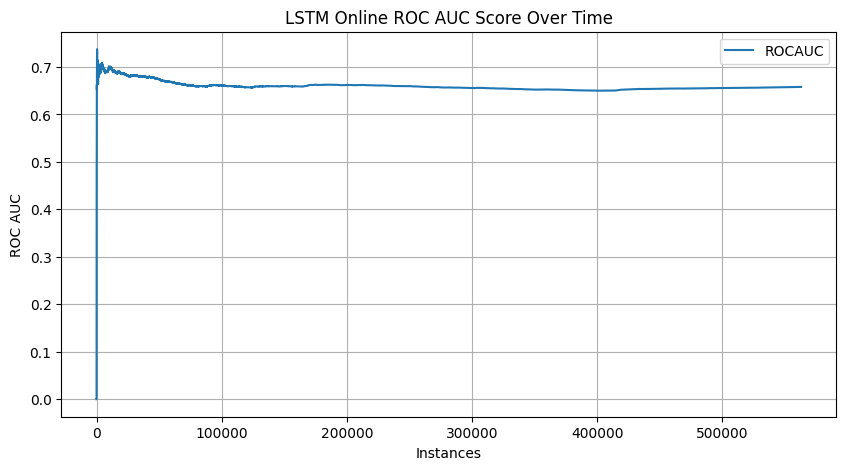

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(rocauc_x_vals, rocauc_y_vals, label='ROCAUC')
plt.xlabel('Instances')
plt.ylabel('ROC AUC')
plt.title('LSTM Online ROC AUC Score Over Time')
plt.grid(True)
plt.legend()
plt.show()


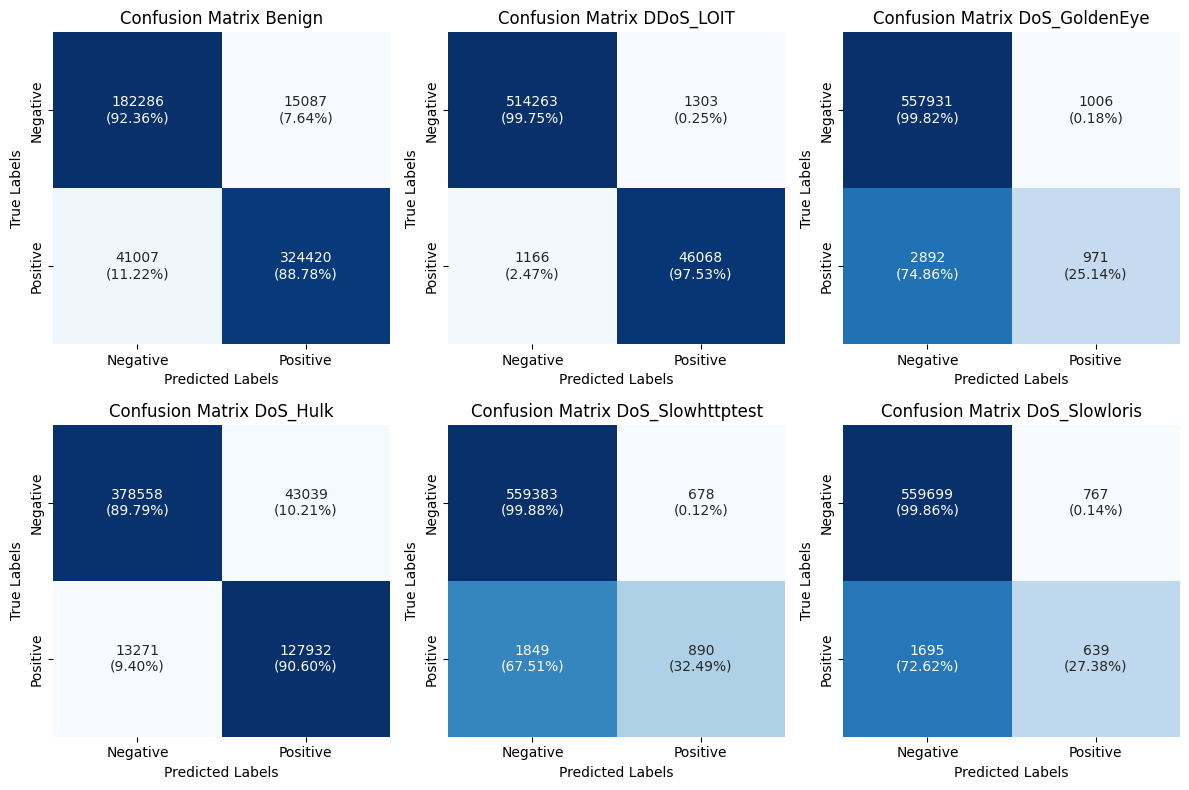

In [19]:

# Compute multilabel confusion matrix
mcm = multilabel_confusion_matrix(ground_truth, predictions)

attack_labels = ["Benign", "DDoS_LOIT", "DoS_GoldenEye", "DoS_Hulk", "DoS_Slowhttptest", "DoS_Slowloris"]

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plot each confusion matrix as a heatmap
for i, ax in enumerate(axes.flat):
    cm = mcm[i]
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Normalize by row (True Labels)
    
    # Annotate with both raw count and percentage
    annotations = []
    for j in range(cm.shape[0]):  # Loop through each row
        row_annotations = []
        for k in range(cm.shape[1]):  # Loop through each column
            count = cm[j, k]
            percentage = cm_percent[j, k]
            row_annotations.append(f'{count}\n({percentage:.2f}%)')
        annotations.append(row_annotations)
    
    # Plot the confusion matrix with both numbers and percentages
    sns.heatmap(cm_percent, annot=annotations, fmt='', cmap='Blues', cbar=False, ax=ax, 
                annot_kws={"size": 10}, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    
    ax.set_title(f'Confusion Matrix {attack_labels[i]}')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

plt.tight_layout()
plt.show()

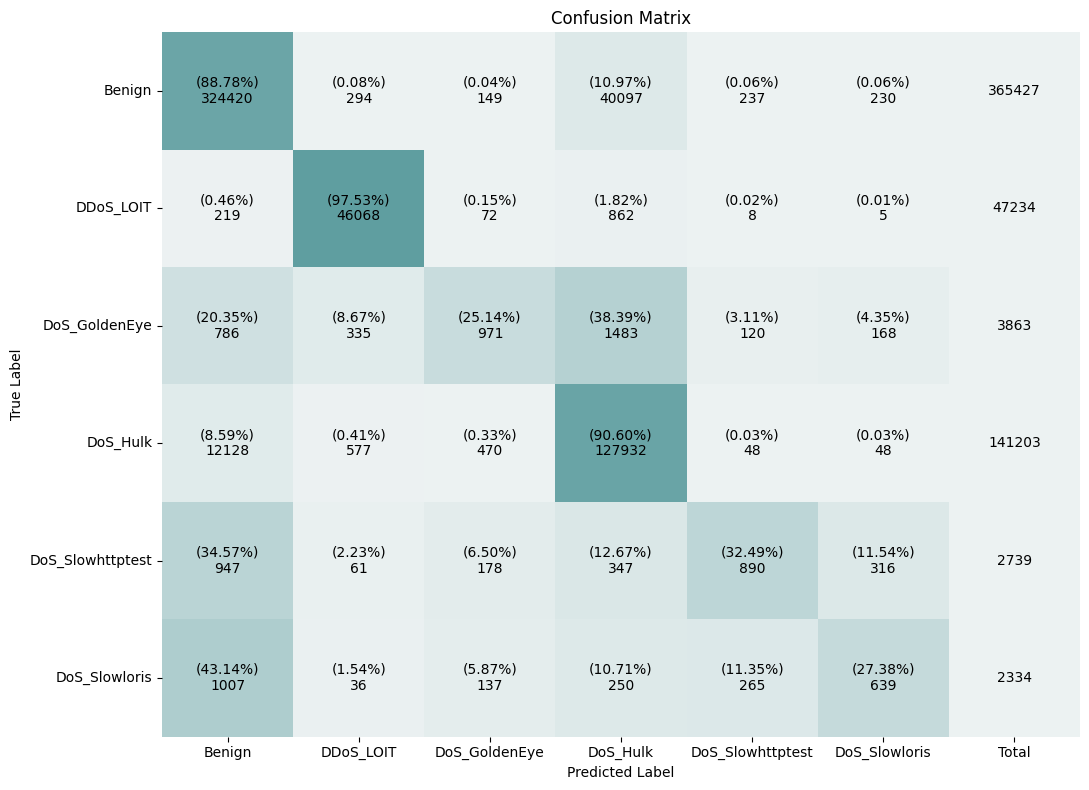

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Labels
attack_labels = ["Benign", "DDoS_LOIT", "DoS_GoldenEye", "DoS_Hulk", "DoS_Slowhttptest", "DoS_Slowloris"]

# Convert integer labels to class names
ground_truth_named = [attack_labels[i] for i in ground_truth]
predictions_named = [attack_labels[i] for i in predictions]

# Compute confusion matrix
cm = confusion_matrix(ground_truth_named, predictions_named, labels=attack_labels)

# Calculate totals per true class
row_totals = cm.sum(axis=1)

# Normalize for percentage display
cm_percent = cm.astype('float') / row_totals[:, np.newaxis] * 100

# Add total column to cm and cm_percent
cm_with_total = np.hstack([cm, row_totals[:, np.newaxis]])
cm_percent_with_total = np.hstack([cm_percent, np.zeros((cm.shape[0], 1))])  # Last column is just 0s for % (not used)

# Create annotations for heatmap
annotations = np.empty_like(cm_with_total).astype(str)
for i in range(cm_with_total.shape[0]):
    for j in range(cm_with_total.shape[1]):
        if j == cm_with_total.shape[1] - 1:  # Last column = total
            annotations[i, j] = f'{cm_with_total[i, j]}'
        else:
            annotations[i, j] = f'({cm_percent_with_total[i, j]:.2f}%)\n{cm_with_total[i, j]}'

# Add "Total" to x-axis labels
xtick_labels = attack_labels + ["Total"]

# Plot
plt.figure(figsize=(11, 8))  # Slightly wider for the extra column

cmap = sns.light_palette("cadetblue", as_cmap=True)

sns.heatmap(cm_percent_with_total, annot=annotations, fmt='', cmap=cmap, cbar=False,
            xticklabels=xtick_labels, yticklabels=attack_labels,
            annot_kws={"size": 10, "color": "black"})

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
